In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
import joblib

# Load the processed dataset
df = pd.read_csv("data/final_datausage_cleaned (2).csv")

# Aggregate data by year, state and strata
grouped = df.groupby(['year', 'state', 'strata'])
df_agg_step = grouped.agg({
    'population': 'sum',
    'Urban population': 'mean',
    'Urban population (% of total population)': 'mean',
    'beds': 'sum',
    'staff_count': 'sum',
    'beds_per_1000': 'mean',
    'staff_per_1000': 'mean',
}).reset_index()

# Calculate elderly population per group
elderly_df = df[df['is_elderly']].groupby(['year', 'state', 'strata'])['population'].sum().reset_index()
elderly_df.rename(columns={'population': 'elderly_population'}, inplace=True)

# Merge and calculate elderly ratio
df_agg_step = pd.merge(df_agg_step, elderly_df, on=['year', 'state', 'strata'], how='left')
df_agg_step['elderly_population'] = df_agg_step['elderly_population'].fillna(0)
df_agg_step['elderly_ratio'] = df_agg_step['elderly_population'] / df_agg_step['population'] * 100

# 🔹 Remove rows with missing values in this important feature
df_agg_step = df_agg_step.dropna(subset=['Urban population (% of total population)'])

# Define features and target
features = ['year', 'state', 'strata', 'population', 
            'Urban population (% of total population)', 'elderly_ratio']
target = 'beds'

X = df_agg_step[features]
y = df_agg_step[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Define preprocessing for categorical columns
categorical_cols = ['state', 'strata']
preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
], remainder='passthrough')

# Create the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Train the model
pipeline.fit(X_train, y_train)

# Predict and evaluate
y_pred = pipeline.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print results
print(f"Model Evaluation:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")

# Feature importance
rf_model = pipeline.named_steps['regressor']
# Get full list of features (OHE + numeric)
cat_features = pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_cols)
all_feature_names = list(cat_features) + [col for col in X.columns if col not in categorical_cols]
importances = pd.Series(rf_model.feature_importances_, index=all_feature_names)

# Top 10 important features
top_features = importances.sort_values(ascending=False).head(10)
print("\nTop 10 Important Features:")
print(top_features)

# Save the pipeline (model + preprocessing)
joblib.dump(pipeline, 'random_forest_pipeline.pkl')

print("Model saved successfully as 'random_forest_pipeline.pkl'")

Model Evaluation:
RMSE: 369829.71
MAE: 263361.03
R²: 0.94

Top 10 Important Features:
population                                  0.858122
state_Sarawak                               0.037627
year                                        0.023316
state_W.P. Kuala Lumpur                     0.021422
Urban population (% of total population)    0.018818
strata_Non-Urban                            0.012281
state_Selangor                              0.009882
state_Melaka                                0.006105
strata_Urban                                0.004181
elderly_ratio                               0.003249
dtype: float64
Model saved successfully as 'random_forest_pipeline.pkl'


In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load your cleaned dataset
df = pd.read_csv("data/final_datausage_cleaned (2).csv")

# Select relevant columns for correlation
corr_columns = [
    'beds',
    'population',
    'staff_count',
    'urban_population_(%_of_total_population)',
    'elderly_ratio'
]

# Compute Pearson correlation matrix
corr_matrix = df[corr_columns].corr(method='pearson')

# Print correlation values for 'beds'
print("Correlation with 'beds':\n")
print(corr_matrix['beds'].sort_values(ascending=False))

# Optional: visualize correlation matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Pearson Correlation Matrix")
plt.tight_layout()
plt.show()


KeyError: "['urban_population_(%_of_total_population)', 'elderly_ratio'] not in index"

In [9]:
print(df.columns.tolist())


['state', 'sex', 'age', 'population', 'is_imputed', 'year', 'is_elderly', 'strata', 'beds', 'staff_count', 'Urban population', 'Urban population (% of total population)', 'beds_per_1000', 'staff_per_1000']


Correlation with 'beds':

beds                                        1.000000
beds_per_1000                               0.360427
staff_count                                 0.144343
population                                  0.041282
Urban population (% of total population)    0.012682
staff_per_1000                             -0.020312
Name: beds, dtype: float64


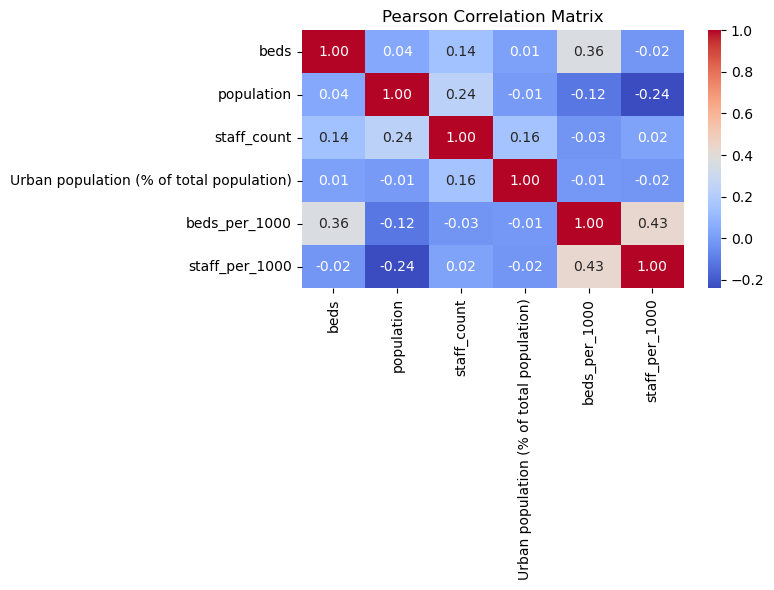

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load your dataset
df = pd.read_csv("data/final_datausage_cleaned (2).csv")

# Define the correct columns using exact names
corr_columns = [
    'beds',
    'population',
    'staff_count',
    'Urban population (% of total population)',  # exact match from your list
    'beds_per_1000',
    'staff_per_1000'
]

# Compute Pearson correlation matrix
corr_matrix = df[corr_columns].corr(method='pearson')

# Print correlation with 'beds'
print("Correlation with 'beds':\n")
print(corr_matrix['beds'].sort_values(ascending=False))

# Optional heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Pearson Correlation Matrix")
plt.tight_layout()
plt.show()
